# EN3160 - Image Assignment 2 - Fitting and Alignment

> Index No: 210610H

> Name : Sirimanna N.T.W.

## Question 1


### 1. Blob Detection Overview
Blob detection is a technique in computer vision that identifies regions in an image that differ in properties like brightness or color compared to their surroundings. In this task, we use the Laplacian of Gaussian (LoG) method and scale-space extrema detection to detect circular objects. This approach is useful for identifying circular blobs of varying sizes, such as sunflower heads in a field.

### 2. Laplacian of Gaussian (LoG) Method
The Laplacian of Gaussian (LoG) filter is designed to detect edges and spots in an image by convolving the image with a Gaussian function followed by the Laplacian operator. The Gaussian smoothing helps reduce noise, and the Laplacian operator identifies regions with rapid intensity changes, such as circular blobs.

The mathematical representation of LoG is:

\[
LoG(x, y) = \nabla^2 (G(x, y) * I(x, y))
\]

where \( G(x, y) \) is the Gaussian function and \( I(x, y) \) is the image.

In this task, applying the LoG method highlights circular regions, allowing us to detect sunflower heads.

### 3. Scale-Space Extrema Detection
To detect circles of various sizes, we use scale-space analysis, which involves examining the image at multiple scales by varying the standard deviation (\( \sigma \)) of the Gaussian. This allows the detection of blobs across different sizes.

The extrema (maxima or minima) in the scale space represent potential blobs. By identifying these extrema, we can find the optimal scale where each blob appears most prominent, giving us the radius of the circle.



Largest Circle Parameters:
Radius: 72.40773439350254
Center Coordinates (x, y): (98, 884)

Range of σ values used:
Minimum σ: 0.4
Maximum σ: 51.200000000000045



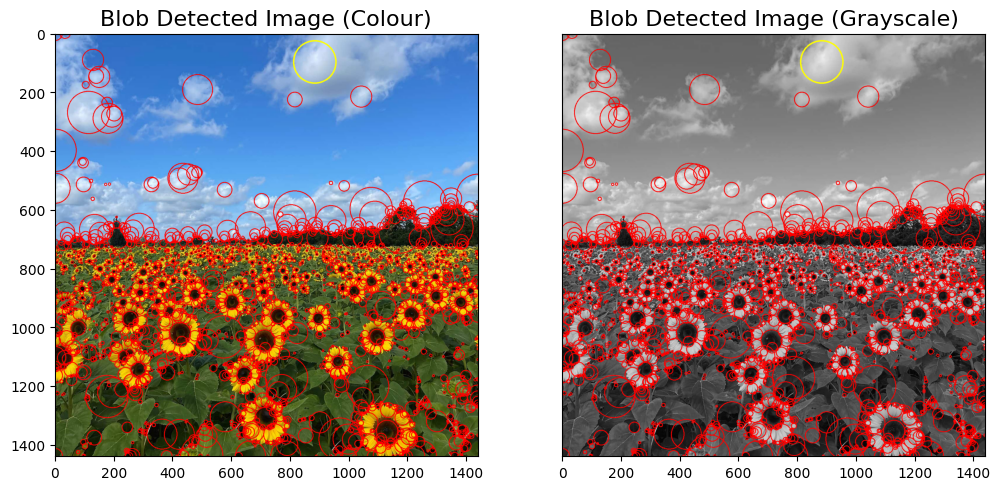

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function Definitions

def log_kernel(sigma, size):

        if size % 2 == 0:  # Size must be odd
                size = size + 1

        sigma2 = sigma ** 2  # Sigma squared
        idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)  # Index range 
        x_idx, y_idx = np.meshgrid(idx_range, idx_range)  # Meshgrid of index range
        tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)  # Calculate the exponential term
        kernel = np.exp(tmp_cal)  # Computes the Gaussian kernel
        kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0  # Discards very small numbers
        k_sum = np.sum(kernel)  # Sums all the elements in the kernel

        if k_sum != 0:
                kernel /= np.sum(kernel)  # Normalizes the kernel

        tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)  # Computes the Laplacian component of the LoG filter
        kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2) # Final LoG filter
        return kernel

def show_kernel(kernel):
        plt.imshow(kernel, cmap='viridis')
        plt.colorbar()
        plt.title('Kernel')
        plt.show()



img = cv.imread("images/the_berry_farms_sunflower_field.jpeg")


gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # Convert to grayscale
gray = np.float32(gray) # Convert to float32
cv.normalize(gray, gray, 1, 0, cv.NORM_MINMAX) # Normalize the image

sigma0 = 0.4 # Initial sigma. Selected through trial and error to produce the best results
k = np.sqrt(2) # Scale factor
num_scales = 15 # Number of scales
sigmas = sigma0 * np.power(k, np.arange(num_scales)) # Array of sigma values for each scale


# LoG Filtering at Multiple Scales
img_stack = None

for i in range(num_scales):

        size = int(2 * np.ceil(4 * sigmas[i]) + 1) # Size of the kernel

        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2) # LoG filter
        #show_kernel(kernel) # Display the kernel

        filtered = cv.filter2D(gray, cv.CV_32F, kernel) # Filter the image with the LoG filter
        filtered = pow(filtered, 2) # Square the filtered image
        
        # Filtered images are stored in img_stack
        if i == 0:  #
                img_stack = filtered 
        else:
                img_stack = np.dstack((img_stack, filtered)) 


# Maximum Response Extraction
scale_space = None 

for i in range(num_scales):
        filtered = cv.dilate(img_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT) # Dilate the image
        
        # Filtered images are stored in scale_space
        if i == 0:
                scale_space = filtered
        else:
                scale_space = np.dstack((scale_space, filtered))


max_stack = np.amax(scale_space, axis=2)  # Find the maximum response across all the dilated images along the third axis (axis=2)
max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)  # Expand the 2D image into a 3D stack of identical 2D images, effectively replicating the maximum response image for each scale
max_stack = np.multiply((max_stack == scale_space), scale_space)  # Multiplies the 3D stack of images by a binary mask. The mask (max_stack == scale_space) will be 1 where the maximum response matches the original scale space and 0 elsewhere. This effectively retains only the maximum responses in the stack.


radius_vec = None
x_vec = None
y_vec = None


for i in range(num_scales):
        
        radius = np.sqrt(2) * sigmas[i] # Radius of the blob
        threshold = 0.01 # Threshold for the maximum response
        # filter out redundant response
        valid = (max_stack[:, :, i] == img_stack[:, :, i]) * img_stack[:, :, i] # Retains only the maximum responses in the stack
        valid[valid <= threshold] = 0 # Discards responses below the threshold
        (x, y) = np.nonzero(valid) # Finds the coordinates of the maximum responses
        
        if i == 1:
                x_vec = x # Creates a vector of the x coordinates of the maximum responses
                y_vec = y # Creates a vector of the y coordinates of the maximum responses               
                radius_vec = np.repeat(radius, np.size(x)) # Creates a vector of the radius of the blob
        else:
                x_vec = np.concatenate((x_vec, x), axis=None) # Concatenates the x coordinates of the maximum responses
                y_vec = np.concatenate((y_vec, y), axis=None) # Concatenates the y coordinates of the maximum responses
                tmp_vec = np.repeat(radius, np.size(x)) # Creates a vector of the radius of the blob
                radius_vec = np.concatenate((radius_vec, tmp_vec), axis=None) # Concatenates the radius vector


# Find the parameters of the largest circles
max_radius = np.max(radius_vec)
max_circle_idx = np.argmax(radius_vec)
max_x = x_vec[max_circle_idx]
max_y = y_vec[max_circle_idx]


# Report the parameters of the largest circles
print()
print(f"Largest Circle Parameters:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates (x, y): ({max_x}, {max_y})")

# Report the range of σ values used
min_sigma = np.min(sigmas)
max_sigma = np.max(sigmas)
print(f"\nRange of σ values used:")
print(f"Minimum σ: {min_sigma}")
print(f"Maximum σ: {max_sigma}")
print()


out = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
out = cv.cvtColor(out, cv.COLOR_GRAY2BGR) 


out_colour    = img.copy()  
out_grayscale = out.copy()


for i in range(np.size(x_vec)):
        if i == max_circle_idx: 
                # Colour the largest circle in yellow
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)   
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)  
        else:
                # Colour the other circles in red
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  

# Save the output images
cv.imwrite("Outputs/the_berry_farms_sunflower_field_blob_detected_COLOUR.jpeg", out_colour)
cv.imwrite("Outputs/the_berry_farms_sunflower_field_blob_detected_GRAY.jpeg", out_grayscale)


# Display the above images using matplot lib as subplots
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(out_colour, cv.COLOR_BGR2RGB))
plt.title("Blob Detected Image (Colour)",fontsize=16)
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(out_grayscale,cv.COLOR_BGR2RGB), cmap='gray') 
plt.yticks([])
plt.title("Blob Detected Image (Grayscale)",fontsize=16)
plt.show()

## Question 2

### Define a function to calculate the line equation using two points

- ax1+by1=d
- ax2+by2=d
- ................................................................................................................................
- y = mx + c
- m = (y2-y1)/(x2-x1)
- c = y1-mx1
- ................................................................................................................................
- mx - y = -c
- ax + by = d
- a = m , b = -1 , d = -c
- Then normalize the equation by dividing by sqrt(a2+b2)

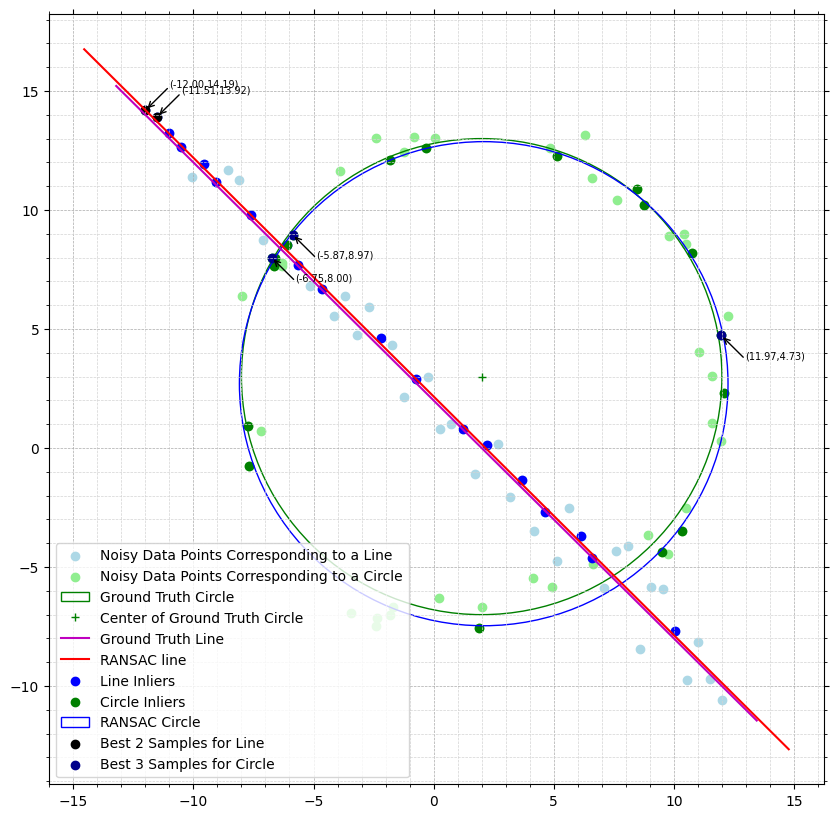

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import math

def find_line_parameters_using_2_points(x1,y1,x2,y2):
        
        m = (y2-y1)/(x2-x1)
        c = y1 - m*x1
        
        a = m
        b = -1
        d = -c
        
        a_normalized = a/math.sqrt(a**2+b**2)
        b_normalized = b/math.sqrt(a**2+b**2)
        d_normalized = d/math.sqrt(a**2+b**2)
        
        return a_normalized,b_normalized,d_normalized

# Define a function to find the line of best fit using RANSAC

def RANSAC_line_fitting(X, iterations, threshold, min_inliers):

    best_model = None
    best_inliers = []

    for i in range(iterations):
        
        sample_indices = np.random.choice(len(X),2,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        
        a,b,d = find_line_parameters_using_2_points(x1,y1,x2,y2)
        
        magnitude = np.sqrt(a**2 + b**2)
        a = a/magnitude
        b = b/magnitude

        distances = np.abs(a*X[:,0]+b*X[:,1]-d)

        inliers  = np.where(distances<threshold)[0]

        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (a,b,d)
                best_inliers = inliers

    return best_model,best_inliers

# Define a function to find the circle equation using three points

def find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3):

    mx1,my1 = (x1+x2)/2,(y1+y2)/2
    mx2,my2 = (x2+x3)/2,(y2+y3)/2

    if y2-y1 == 0:
        slope1 = 0 
    else:
        slope1 = (x2-x1)/(y2-y1)

    if y3-y2 == 0:
        slope2 = 0 
    else:
        slope2 = (x3-x2)/(y3-y2)

    x_center = (slope1*mx1-slope2*mx2+my2-my1)/(slope1-slope2)
    y_center = -slope1*(x_center-mx1)+my1

    radius = np.sqrt((x1-x_center)**2+(y1-y_center)**2)

    return x_center,y_center,radius

# Define a function to find the circle of best fit using RANSAC

def RANSAC_circle_fitting(X,iterations,threshold,min_inliers):
    
    best_model   = None
    best_inliers = []
    
    for i in range(iterations):
        sample_indices = np.random.choice(len(X),3,replace=False)
        x1,y1 = X[sample_indices[0]]
        x2,y2 = X[sample_indices[1]]
        x3,y3 = X[sample_indices[2]]
        
        x_center,y_center,radius = find_circle_parameters_using_3_points(x1,y1,x2,y2,x3,y3)
        
        errors  = np.abs(np.sqrt((X[:,0]-x_center)**2+(X[:,1]-y_center)**2)-radius)
        
        inliers = np.where(errors<threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model   = (x_center,y_center,radius)
                best_inliers = inliers
                
    return best_model,best_inliers

# Noisy Data Generation & Getting Required Results & Plots

# Generate noisy data points corresponding to a circle and a line
np.random.seed(1)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2,3  # Center 
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s * np.random.randn(half_n)
x = x0_gt+(r+n)*np.cos(t)
y = y0_gt+(r+n)*np.sin(t)
X_circ = np.column_stack((x, y))
s = 1.0
m,b = -1,2
x = np.linspace(-12,12,half_n)
y = m*x+b+s*np.random.randn(half_n)
X_line = np.column_stack((x,y))
X = np.vstack((X_circ,X_line))
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(X_line[:,0],X_line[:,1],label='Noisy Data Points Corresponding to a Line',color='lightblue')
ax.scatter(X_circ[:,0],X_circ[:,1],label='Noisy Data Points Corresponding to a Circle',color='lightgreen')
circle_gt = plt.Circle((x0_gt,y0_gt),r,color='g',fill=False,label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt,y0_gt,'+',label='Center of Ground Truth Circle',color='g')
x_min,x_max = ax.get_xlim()
x_ = np.array([x_min,x_max])
y_ = m*x_+b
plt.plot(x_,y_,color='m',label='Ground Truth Line')



# RANSAC parameters for line estimation
iterations  = 100000
threshold   = 0.2
min_inliers = 15

# Estimate the line using RANSAC
best_RANSAC_line,line_inlier_indices_array = RANSAC_line_fitting(X_line,iterations,threshold,min_inliers)

# RANSAC parameters for circle estimation
circle_iterations  = 100000
circle_threshold   = 0.2  
circle_min_inliers = 15

remnant_indices = [i for i in range(len(X)) if i not in line_inlier_indices_array]
remnant_points  = X[remnant_indices]

# Estimate the circle using RANSAC
best_RANSAC_circle, circle_inlier_indices_array = RANSAC_circle_fitting(remnant_points,circle_iterations,circle_threshold,circle_min_inliers)

# Plot the line estimated by RANSAC
x_min,x_max = ax.get_xlim()
x_ = np.array([x_min,x_max])
y_ = (-best_RANSAC_line[0]*x_+best_RANSAC_line[2])/best_RANSAC_line[1]
plt.plot(x_,y_,label='RANSAC line',color='red')

# Plot the inliers of the line
ax.scatter(X_line[line_inlier_indices_array, 0],X_line[line_inlier_indices_array, 1],color='blue',label='Line Inliers')

# Find the best 2 samples for the line (using line_inlier_indices_array)
best_line_sample_indices = line_inlier_indices_array[:2]
best_line_samples = X_line[best_line_sample_indices]

ax.scatter(remnant_points[circle_inlier_indices_array,0],remnant_points[circle_inlier_indices_array,1],color='g',label='Circle Inliers')

# Plot the circle estimated by RANSAC
x_center,y_center,radius = best_RANSAC_circle
circle_estimated = plt.Circle((x_center,y_center),radius,color='blue',fill=False,label='RANSAC Circle')
ax.add_patch(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices_array)
best_circle_sample_indices = circle_inlier_indices_array[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]

# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:,0], best_line_samples[:,1],color='black',marker='o',label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:,0], best_circle_samples[:,1],color='darkblue',marker='o',label='Best 3 Samples for Circle')

# Annotations
def annotate_sample(ax,start,end,label):
        ax.annotate("",xy=start,xytext=end,arrowprops=dict(arrowstyle="->",color='black'))
        ax.text(end[0],end[1],label,fontsize=7,ha='left')
for i, sample in enumerate(best_line_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax,(sample[0],sample[1]),(sample[0]+1,sample[1]+1),label)
for i, sample in enumerate(best_circle_samples):
        label = f'({sample[0]:.2f},{sample[1]:.2f})'
        annotate_sample(ax,(sample[0],sample[1]),(sample[0]+1,sample[1]-1),label)

# Plot settings
ax.tick_params(which='both', top=True, bottom=True, left=True, right=True)
ax.minorticks_on()
ax.grid(True, which='minor', linestyle='--', linewidth=0.5, color='lightgray')
ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='darkgray')
plt.legend()
plt.show()

# Save the figure
fig.savefig('Outputs/RANSAC.png',dpi=300)

## Question 3

Selected points: [[220, 154], [470, 308], [204, 443], [471, 492]]


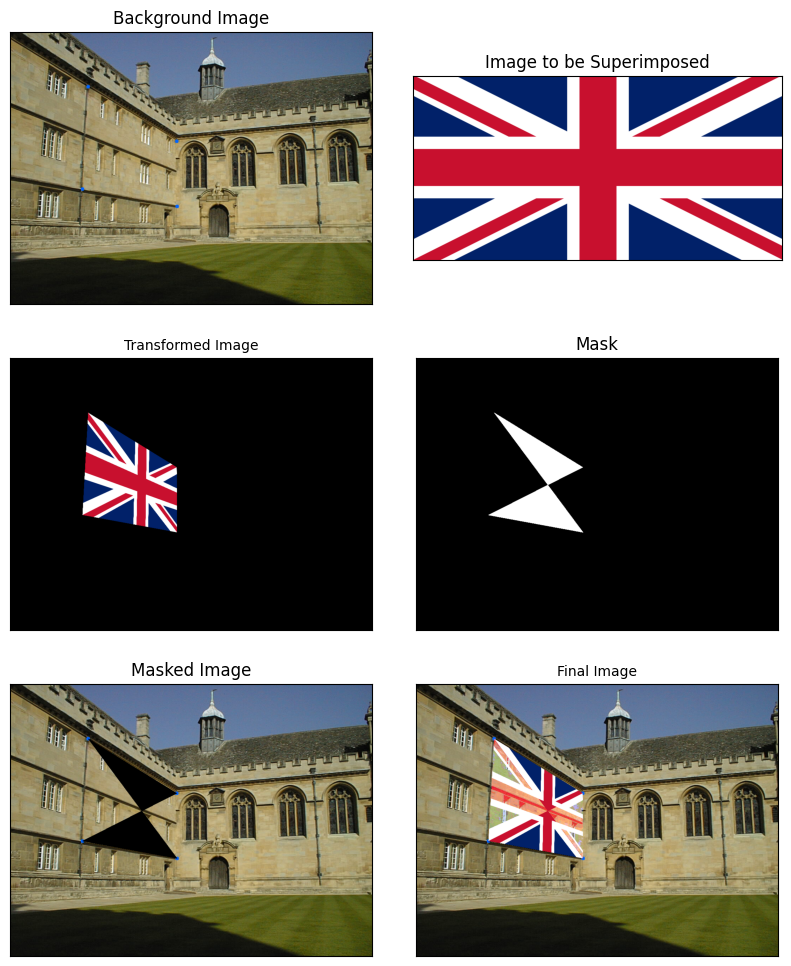

In [37]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def selecting_points(event, x, y, flags, param):
    global positions, count
    if event == cv.EVENT_LBUTTONUP:
        cv.circle(background_image, (x, y), 5, (255, 100, 0), -1)
        positions.append([x, y])
        count += 1

# Load images
background_image = cv.imread('images/005.jpg')
image_to_superimpose = cv.imread('images/flag.png')

# Initialize global variables
positions = []  # List to store selected coordinates
count = 0       # Number of points selected

cv.namedWindow('Select Points')  # Window to display the background image
cv.setMouseCallback('Select Points', selecting_points)

# Main loop to capture mouse clicks
while True:
    cv.imshow('Select Points', background_image)
    k = cv.waitKey(20)
    if k == 27:  # Escape key to exit
        break
    if len(positions) >= 4:  # Exit if 4 points have been selected
        print("Selected points:", positions[:4])
        break

cv.destroyAllWindows()

# Check if at least 4 points have been selected
if len(positions) < 4:
    print("Not enough points selected.")
    exit(1)

# Extract dimensions
height_background, width_background = background_image.shape[:2]
height_superimposing_image, width_superimposing_image = image_to_superimpose.shape[:2]

# Define source and destination points for homography
pts1 = np.float32([[0, 0], [width_superimposing_image, 0],
                   [0, height_superimposing_image], 
                   [width_superimposing_image, height_superimposing_image]])
pts2 = np.float32(positions[:4])

# Calculate the perspective transformation matrix
h, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 5.0)

# Apply the perspective transformation
perspective_transformed_superimposing_image = cv.warpPerspective(image_to_superimpose, h, (width_background, height_background))

# Create a mask for the background image
background_mask = np.zeros(background_image.shape[:2], dtype=np.uint8)

# Define the region of interest using the selected positions
roi_points = np.array(positions[:4], dtype=np.int32)  # Use the first four selected points
cv.fillPoly(background_mask, [roi_points], 255)  # Fill the ROI with white

# Invert the mask 
background_mask_inv = cv.bitwise_not(background_mask)

# Apply the mask to the background image
masked_image = cv.bitwise_and(background_image, background_image, mask=background_mask_inv)

# Superimpose the transformed image on the masked background
final_image = cv.bitwise_or(perspective_transformed_superimposing_image, masked_image)

# Save the final image
cv.imwrite('Outputs/Superimposed_college_FINAL_IMAGE_ONLY.jpg', final_image)

# Display and save plots
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.subplot(3, 2, 1)
plt.imshow(cv.cvtColor(background_image, cv.COLOR_BGR2RGB))
plt.title('Background Image', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 2)
plt.imshow(cv.cvtColor(image_to_superimpose, cv.COLOR_BGR2RGB))
plt.title('Image to be Superimposed', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 3)
plt.imshow(cv.cvtColor(perspective_transformed_superimposing_image, cv.COLOR_BGR2RGB))
plt.title('Transformed Image', fontsize=10)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 4)
plt.imshow(background_mask, cmap='gray')
plt.title('Mask', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 5)
plt.imshow(cv.cvtColor(masked_image, cv.COLOR_BGR2RGB))
plt.title('Masked Image', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 6)
plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
plt.title('Final Image', fontsize=10)
plt.xticks([]), plt.yticks([])

plt.savefig('Outputs/Superimposed_college.png')
plt.show()

Selected points: [[371, 195], [822, 124], [368, 349], [821, 335]]


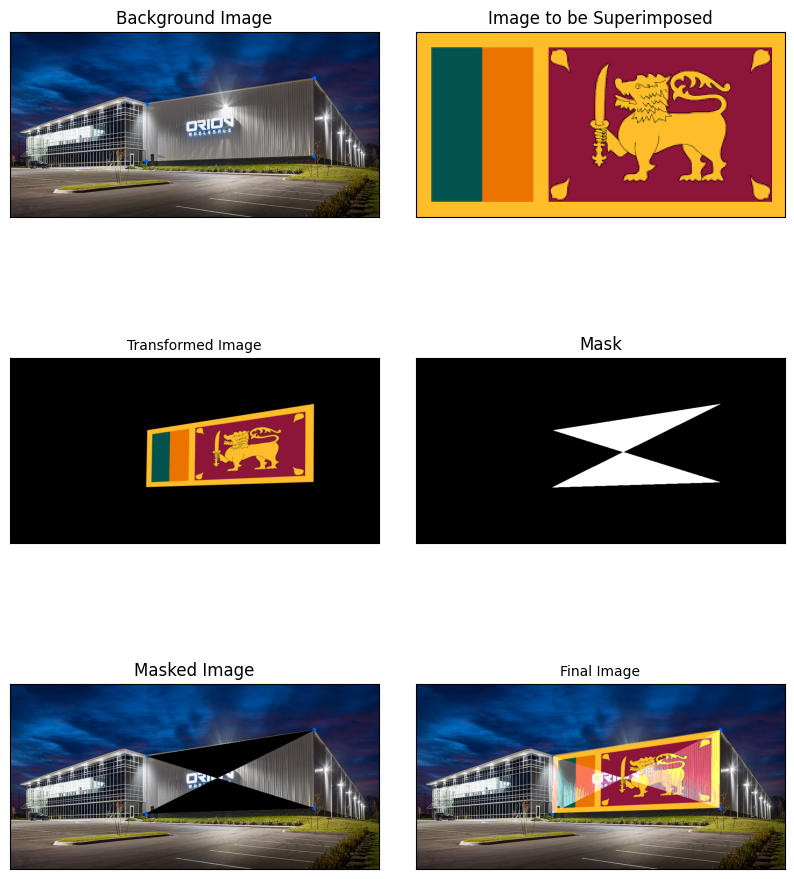

In [47]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def selecting_points(event, x, y, flags, param):
    global positions, count
    if event == cv.EVENT_LBUTTONUP:
        cv.circle(background_image, (x, y), 5, (255, 100, 0), -1)
        positions.append([x, y])
        count += 1

# Load images
background_image = cv.imread('images/house.jpg')
image_to_superimpose = cv.imread('images/slflag.png')

# Initialize global variables
positions = []  # List to store selected coordinates
count = 0       # Number of points selected

cv.namedWindow('Select Points')  # Window to display the background image
cv.setMouseCallback('Select Points', selecting_points)

# Main loop to capture mouse clicks
while True:
    cv.imshow('Select Points', background_image)
    k = cv.waitKey(20)
    if k == 27:  # Escape key to exit
        break
    if len(positions) >= 4:  # Exit if 4 points have been selected
        print("Selected points:", positions[:4])
        break

cv.destroyAllWindows()

# Check if at least 4 points have been selected
if len(positions) < 4:
    print("Not enough points selected.")
    exit(1)

# Extract dimensions
height_background, width_background = background_image.shape[:2]
height_superimposing_image, width_superimposing_image = image_to_superimpose.shape[:2]

# Define source and destination points for homography
pts1 = np.float32([[0, 0], [width_superimposing_image, 0],
                   [0, height_superimposing_image], 
                   [width_superimposing_image, height_superimposing_image]])
pts2 = np.float32(positions[:4])

# Calculate the perspective transformation matrix
h, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 5.0)

# Apply the perspective transformation
perspective_transformed_superimposing_image = cv.warpPerspective(image_to_superimpose, h, (width_background, height_background))

# Create a mask for the background image
background_mask = np.zeros(background_image.shape[:2], dtype=np.uint8)

# Define the region of interest using the selected positions
roi_points = np.array(positions[:4], dtype=np.int32)  # Use the first four selected points
cv.fillPoly(background_mask, [roi_points], 255)  # Fill the ROI with white

# Invert the mask 
background_mask_inv = cv.bitwise_not(background_mask)

# Apply the mask to the background image
masked_image = cv.bitwise_and(background_image, background_image, mask=background_mask_inv)

# Superimpose the transformed image on the masked background
final_image = cv.bitwise_or(perspective_transformed_superimposing_image, masked_image)

# Save the final image
cv.imwrite('Outputs/Superimposed_derana_FINAL_IMAGE_ONLY.jpg', final_image)

# Display and save plots
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.subplot(3, 2, 1)
plt.imshow(cv.cvtColor(background_image, cv.COLOR_BGR2RGB))
plt.title('Background Image', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 2)
plt.imshow(cv.cvtColor(image_to_superimpose, cv.COLOR_BGR2RGB))
plt.title('Image to be Superimposed', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 3)
plt.imshow(cv.cvtColor(perspective_transformed_superimposing_image, cv.COLOR_BGR2RGB))
plt.title('Transformed Image', fontsize=10)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 4)
plt.imshow(background_mask, cmap='gray')
plt.title('Mask', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 5)
plt.imshow(cv.cvtColor(masked_image, cv.COLOR_BGR2RGB))
plt.title('Masked Image', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 6)
plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
plt.title('Final Image', fontsize=10)
plt.xticks([]), plt.yticks([])

plt.savefig('Outputs/Superimposed_derana.png')
plt.show()

## Question 4

In [50]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def Find_Features(image):
    
    sift = cv.SIFT_create()
    keypoint, descriptor = sift.detectAndCompute(image, None)
    return keypoint, descriptor

def Find_Matches_By_Brute_Force(des1, des5):
    
    brute_force_matcher = cv.BFMatcher()
    matches = brute_force_matcher.knnMatch(des1, des5, k=2)
    return matches

def Process_Image(image_path):
    
    image = cv.imread(image_path)
    image_grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    sift = cv.SIFT_create()
    keypoint, descriptor = sift.detectAndCompute(image_grayscale, None)
    return image, keypoint, descriptor

def Calculate_Homography_Matrix(sample):
    
    M = []
    
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        M.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        M.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
        
    M = np.matrix(M)
    U, S, V = np.linalg.svd(M)
    H = np.reshape(V[-1], (3, 3))
    H = (1/H.item(8))*H
    return H

def Calculate_Geometric_Distance(H, correspondence):
    
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def Final_Homography_Matrix_Using_RANSAC(corres,threshold):
    
    max_inliers = []
    homography = []
    
    for i in range(100):
        corr1 = corres[np.random.randint(0, len(corres))]
        corr2 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((corr1, corr2))
        corr3 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr3))
        corr4 = corres[np.random.randint(0, len(corres))]
        sample = np.vstack((sample, corr4))
        h = Calculate_Homography_Matrix(sample)
        inliers = np.zeros((1,4))
        
        for j in range(len(corres)):
            distance = Calculate_Geometric_Distance(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers,corres[j]))

        inliers = np.delete(inliers,0,0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = Calculate_Homography_Matrix(max_inliers)

    return homography,max_inliers


### Displaying matches between img1 and img5

((< cv2.DMatch 0000026013030650>, < cv2.DMatch 0000026013030490>), (< cv2.DMatch 0000026013032B10>, < cv2.DMatch 0000026013030910>), (< cv2.DMatch 0000026013032870>, < cv2.DMatch 0000026013033710>), (< cv2.DMatch 0000026013030750>, < cv2.DMatch 00000260130324F0>), (< cv2.DMatch 0000026013033590>, < cv2.DMatch 0000026013030D30>))


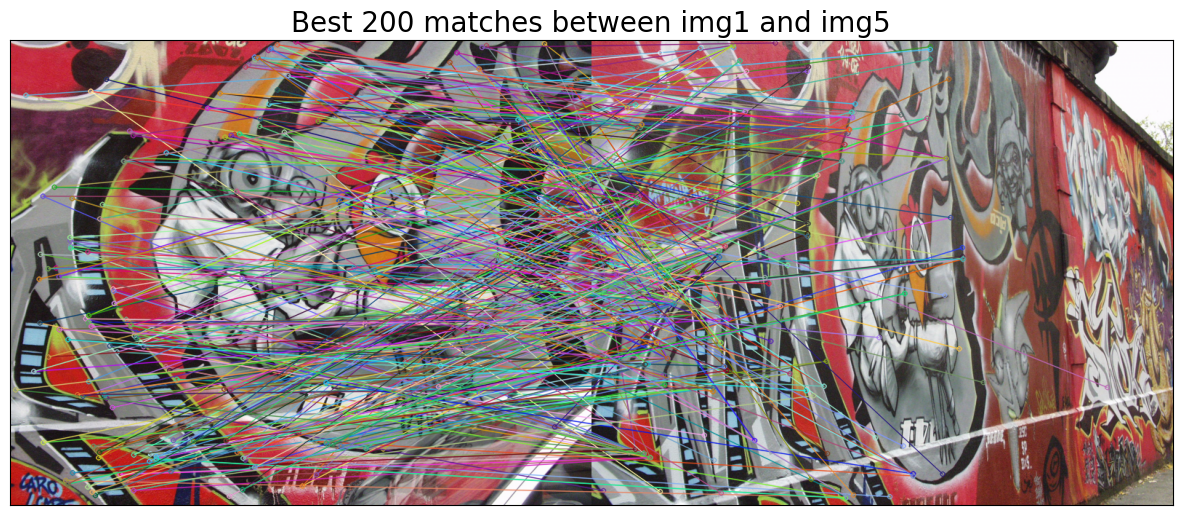

In [52]:
img1 = cv.imread('images/graf/img1.ppm')
img5 = cv.imread('images/graf/img5.ppm')

img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()
brute_force_matcher = cv.BFMatcher()

key1, des1 = sift.detectAndCompute(img1_gray, None)
key5, des5 = sift.detectAndCompute(img5_gray, None)

matches = brute_force_matcher.knnMatch(des1, des5, k=2)
print(matches[:5])
matches = sorted(matches, key=lambda x:x[0].distance)

out_img = cv.drawMatchesKnn(img1, key1, img5, key5, matches[:200], img5, flags=2) 
fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Best 200 matches between img1 and img5', fontsize=20)
plt.show()

It is evident that there are not many good matches between images 1 and 5. We will get a poor result if we use these matches to calculate the homography matrix. 

In order to compute the homography matrix, I will use all of the images rather than just images IMG1 and IMG5, taking into account the matches between IMG1 and IMG2, IMG2 and IMG3, IMG3 and IMG4, and IMG4 and IMG5. The final homography matrix will then be obtained by combining all of the homography matrices. 

### Displaying matches between all images

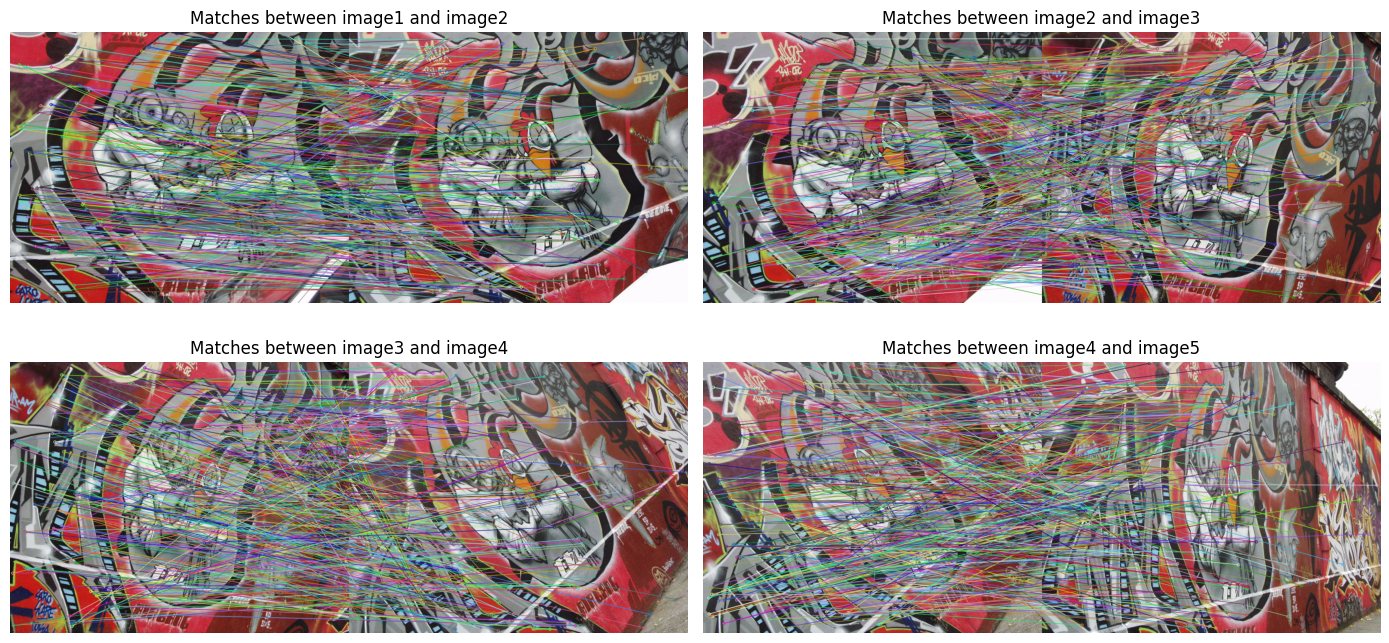

In [54]:
image_paths = ['images/graf/img1.ppm', 'images/graf/img2.ppm', 'images/graf/img3.ppm', 'images/graf/img4.ppm', 'images/graf/img5.ppm']

fig, axes = plt.subplots(2, 2, figsize=(14, 7))

for i in range(4):
    img1, key1, des1 = Process_Image(image_paths[i])
    img2, key2, des2 = Process_Image(image_paths[i+1])
    brute_force_matcher = cv.BFMatcher()
    matches = brute_force_matcher.knnMatch(des1, des2, k=2)
    matches = sorted(matches, key=lambda x: x[0].distance)
    out_img = cv.drawMatchesKnn(img1, key1, img2, key2, matches[:200], img2, flags=2)
    row = i // 2
    col = i % 2
    axes[row, col].imshow(out_img)
    axes[row, col].set_title(f'Matches between image{i+1} and image{i+2}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Calculating the homography matrix using the defined functions

In [57]:
image_array = []

for i in range(1,6):
    image = cv.imread('images/graf/img'+str(i)+'.ppm')
    image_array.append(image)

homographs = []
threshold = 100

for i in range(4):
    correspondence = []
    key1, des1 = Find_Features(image_array[i])
    key5, des5 = Find_Features(image_array[i+1])
    keypoints = [key1, key5]
    matches = Find_Matches_By_Brute_Force(des1, des5)
    for match in matches:
        (x1, y1) = keypoints[0][match[0].queryIdx].pt
        (x2, y2) = keypoints[1][match[0].trainIdx].pt
        correspondence.append([x1, y1, x2, y2])
    corres = np.matrix(correspondence)
    H,inliers =Final_Homography_Matrix_Using_RANSAC(corres,threshold)
    homographs.append(H)

final_homograph = homographs[3]@homographs[2]@homographs[1]@homographs[0]
final_homograph = (1/final_homograph.item(8))*final_homograph
print('Calculated Homography\n',final_homograph)
print('Number of inliers',len(inliers))
print()
print('Original Homography\n',open('images/graf/H1to5p.txt').read())

Calculated Homography
 [[ 6.32630848e-01  5.87548657e-02  2.21152548e+02]
 [ 2.30832730e-01  1.15830463e+00 -2.64597356e+01]
 [ 5.11904786e-04 -5.67875219e-05  1.00000000e+00]]
Number of inliers 1288

Original Homography
    6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



We can see that the calculated homography matrix is very similar to the ground truth homography matrix.

### Stiching images using the calculated homography matrix

(np.float64(-0.5), np.float64(799.5), np.float64(639.5), np.float64(-0.5))

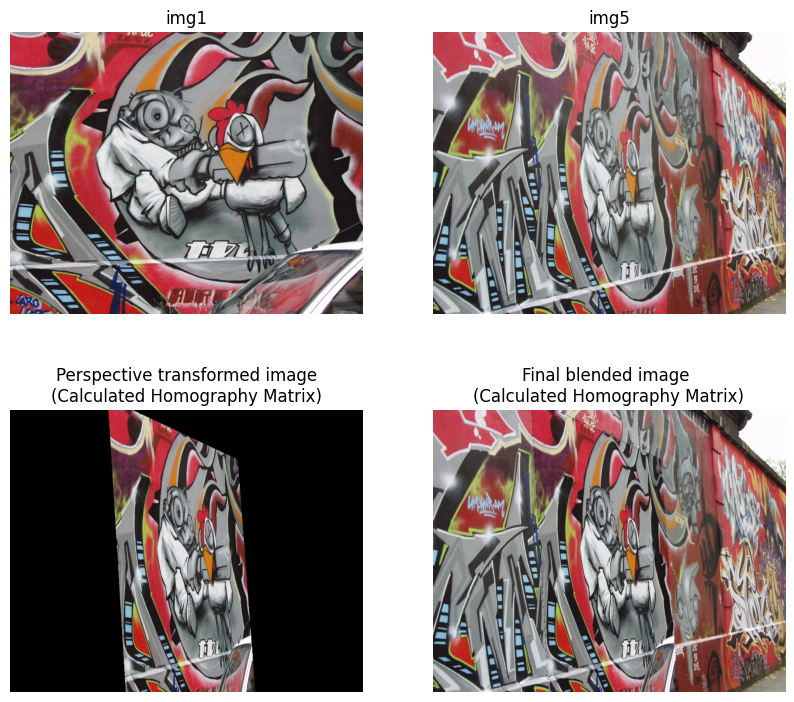

In [58]:
calculated_H = final_homograph

img1 = cv.imread('images/graf/img1.ppm')
img5 = cv.imread('images/graf/img5.ppm')
fig = plt.figure(figsize=(10, 9))
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')

image_perspective = cv.warpPerspective(img1, calculated_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective transformed image\n(Calculated Homography Matrix)') 
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)

plt.subplot(2,2,4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB)) 
plt.title('Final blended image \n(Calculated Homography Matrix)')
plt.axis('off') 

### Stiching images using the homography matrix given in the dataset

(640, 800, 3)
(640, 800, 3)


(np.float64(-0.5), np.float64(799.5), np.float64(639.5), np.float64(-0.5))

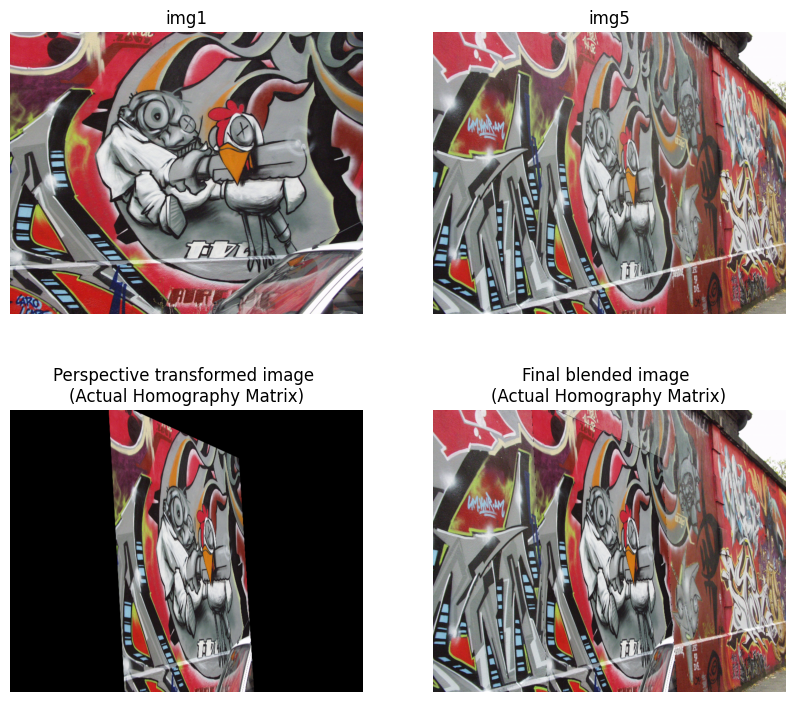

In [59]:
img1 = cv.imread('images/graf/img1.ppm')
img5 = cv.imread('images/graf/img5.ppm')

fig = plt.figure(figsize=(10, 9))
plt.subplot(2,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5')
plt.axis('off')
print(img1.shape)
print(img5.shape)

h_text = open('images/graf/H1to5p.txt','r')

original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)
original_H = np.matrix(original_H)

image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))
plt.subplot(2,2,3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective transformed image \n(Actual Homography Matrix)')
plt.axis('off')

threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
plt.subplot(2,2,4)
plt.imshow(output_image) 
plt.title('Final blended image \n(Actual Homography Matrix)')
plt.axis('off')

Git link : 